# Persistence algorithm 을 이용한 forecasting 

- Persistence Algorithm : last value 를 next value 로 예측에 사용


- 약간의 noise 를 추가한 seasonality 와 trend 가 있는 인공 합성 time series 이용 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(101)

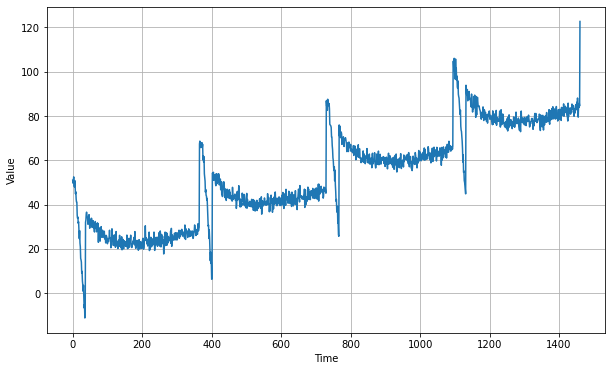

In [2]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의의 pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """매 기간 마다 동일 pattern 반복"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")   # 4 년
baseline = 10          # 기본값
series = trend(time, 0.1)      # trend 시계열 data 
amplitude = 40
slope = 0.01
noise_level = 2

# series data 생성
series = baseline + 0.05 * time + \
         seasonality(time, period=365, amplitude=amplitude) 

# noise 추가
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plt.plot(series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [3]:
series.shape

(1461,)

### 위에서 생성한 time series 를 train 와 validation set 으로 분할

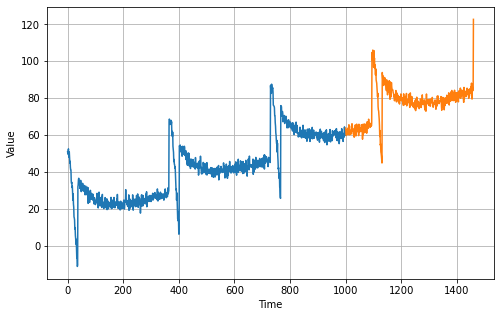

In [4]:
split_time = 1000

time_train = time[:split_time]
X_train = series[:split_time]

time_test = time[split_time:]
X_test = series[split_time:]

plt.figure(figsize=(8, 5))
plt.plot(time_train, X_train)
plt.plot(time_test, X_test)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

## Naive Forecast

- last value 를 prediction 으로 사용 -> one-step behind prediction

In [5]:
naive_forecast = series[split_time-1:-1]
naive_forecast[:10]

array([62.09912 , 63.789005, 62.876087, 61.182796, 59.806553, 62.53394 ,
       61.96171 , 63.002544, 62.520092, 63.386612], dtype=float32)

In [6]:
X_test[:10]

array([63.789005, 62.876087, 61.182796, 59.806553, 62.53394 , 61.96171 ,
       63.002544, 62.520092, 63.386612, 60.254963], dtype=float32)

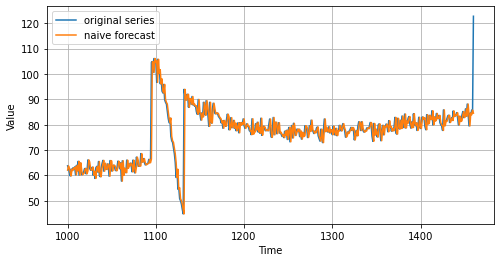

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(time_test, X_test, label='original series')
plt.plot(time_test, naive_forecast, label='naive forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()

naive forecast 가 one-step behind 인지 그래프상으로 구별 어려우므로 validation period 의 앞부분으로 zoom in.

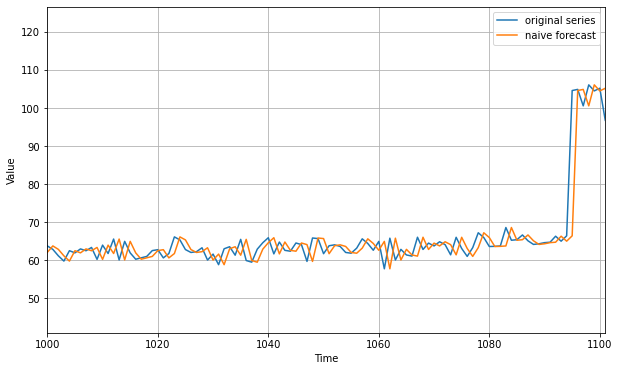

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, X_test, label='original series')
plt.plot(time_test, naive_forecast, label='naive forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim(1000, 1101)
plt.grid(True)
plt.legend()

- naive forecast 가 1 step behind 지연되어 time series 를 그대로 재현하고 있음

### naive forecast 와 validation period 값 간의 차이를  mse 와 mae 로 계산

In [9]:
print(mean_squared_error(X_test, naive_forecast))
print(mean_absolute_error(X_test, naive_forecast))

20.167189
2.5842602


### 위의 값을 모든 prediction model 의 최소 성능의 baseline 으로 한다. 

# Real Data를 이용한 Naive Forecasting

`datetime.strptime` : 주어진 문자열에서 datetime 객체를 생성합니다.

```
"Month","Sales"
"1-01",266.0
"1-02",145.9
"1-03",183.1
"1-04",119.3
```

In [15]:
def parser(x):
    return datetime.strptime('190' + x, '%Y-%m')

In [16]:
url = "https://raw.githubusercontent.com/ironmanciti/Time_Series_Lecture/main/datasets/shampoo-sales.csv"
series = pd.read_csv(url, parse_dates=[0], 
                     date_parser=parser, index_col=0, header=0)
series.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


<AxesSubplot:xlabel='Month'>

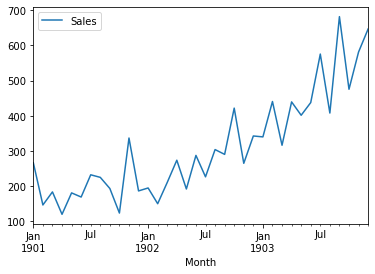

In [17]:
series.plot()

### Train / Test set 분리

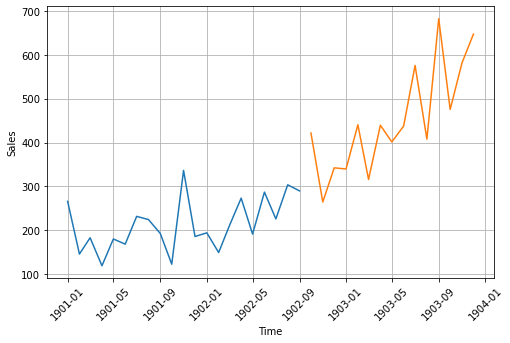

In [18]:
split_time = int(len(series) * 0.6)

X_train = series[:split_time]

X_test = series[split_time:]

plt.figure(figsize=(8, 5))
plt.plot(series.index[:split_time], X_train)
plt.plot(series.index[split_time:], X_test)
plt.xlabel("Time")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Persistence Algorithm define

In [19]:
def model_persistence(series, split_time):
    return series[split_time-1:-1]

### Forecast and Evaluation

In [20]:
prediction = model_persistence(series, split_time)

test_score = mean_squared_error(X_test, prediction)
print('Test MSE: {:.3f}'.format(test_score))

Test MSE: 18168.136


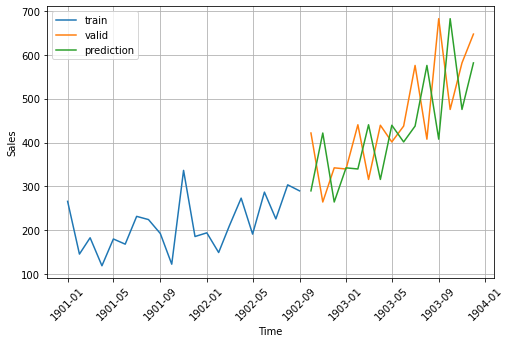

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(series.index[:split_time], X_train, label='train')
plt.plot(series.index[split_time:], X_test, label='valid')
plt.plot(series.index[split_time:], prediction, label='prediction')
plt.xlabel("Time")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()